**РК2**

**Хаммуд Хала ИУИ5-21М, Классификаторы KNeighborsClassifier и LogisticRegression**

**Тема:** Методы обработки текстов. Решение задачи классификации текстов.

**Задание:** Необходимо решить задачу классификации текстов на основе любого выбранного Вами датасета (кроме примера, который рассматривался в лекции). Классификация может быть бинарной или многоклассовой. Целевой признак из выбранного Вами датасета может иметь любой физический смысл, примером является задача анализа тональности текста.

Необходимо сформировать два варианта векторизации признаков - на основе CountVectorizer и на основе TfidfVectorizer.

In [14]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import urllib.request
import tarfile
import os

# Загрузка стоп-слов
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from google.colab import files
uploaded = files.upload()




Saving Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv to Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19 (1).csv


In [20]:
# Чтение Excel-файла
df = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")


# Просмотр названий столбцов
print(df.columns)



Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')


In [22]:
# Преобразование рейтинга в бинарные метки
def convert_rating_to_label(rating):
    if rating in [1, 2]:
        return 0  # негативный
    elif rating in [4, 5]:
        return 1  # позитивный
    else:
        return None  # нейтральный, исключаем

# Применение и удаление нейтральных отзывов
df['label'] = df['reviews.rating'].apply(convert_rating_to_label)
df = df.dropna(subset=['label'])  # Удаляем нейтральные
df['label'] = df['label'].astype(int)




<ipython-input-22-859cd7070645>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype(int)


In [24]:
# Сброс индекса после удаления нейтральных отзывов
df = df.reset_index(drop=True)

# Проверка примера отзыва
print("Пример отзыва:")
print(df['reviews.text'][0][:500] + "...")




Пример отзыва:
Bulk is always the less expensive way to go for products like these...


In [25]:
# Предобработка текста
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Удаление спецсимволов и чисел
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление стоп-слов и стемминг
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

# ✅ Применение к полю reviews.text
df['cleaned_text'] = df['reviews.text'].apply(preprocess_text)

# Проверка результата
print("Текст до обработки:\n", df['reviews.text'][0][:200] + "...")
print("\nТекст после обработки:\n", df['cleaned_text'][0][:200] + "...")


Текст до обработки:
 Bulk is always the less expensive way to go for products like these...

Текст после обработки:
 bulk alway less expens way product like...


In [7]:
# Предобработка текста
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Удаление спецсимволов и чисел
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление стоп-слов и стемминг
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

# Применение предобработки
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Проверка результата
print("Текст до обработки:\n", df['text'][0][:200] + "...")
print("\nТекст после обработки:\n", df['cleaned_text'][0][:200] + "...")


Текст до обработки:
 The food was amazing and the service was excellent!...

Текст после обработки:
 food amaz servic excel...


In [26]:
# Разделение данных на обучающую и тестовую выборки
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")


Размер обучающей выборки: 21700
Размер тестовой выборки: 5426


In [27]:
# Векторизация текстов - CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

print(f"Размерность CountVectorizer (train): {X_train_counts.shape}")
print(f"Размерность CountVectorizer (test): {X_test_counts.shape}")


Размерность CountVectorizer (train): (21700, 5000)
Размерность CountVectorizer (test): (5426, 5000)


In [29]:
# Импорт необходимых библиотек (если ещё не подключены)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ✅ Функция для обучения и оценки моделей (специально для Hala)
def train_and_evaluate_model(model, X_train_vec, y_train_data, X_test_vec, y_test_data, model_name, vectorizer_name):
    print(f"--- Обучение и оценка: {model_name} с {vectorizer_name} ---")

    # Обучение модели
    model.fit(X_train_vec, y_train_data)

    # Предсказание
    y_pred = model.predict(X_test_vec)

    # Метрики качества
    accuracy = accuracy_score(y_test_data, y_pred)
    report = classification_report(y_test_data, y_pred, output_dict=True)

    # Печать результатов
    print(f"Точность (Accuracy): {accuracy:.4f}")
    print("Отчет по классификации:")
    print(classification_report(y_test_data, y_pred))

    # Матрица ошибок
    cm = confusion_matrix(y_test_data, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок: {model_name} с {vectorizer_name}')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.show()

    return {
        'model': model_name,
        'vectorizer': vectorizer_name,
        'accuracy': accuracy,
        'report': report
    }

# ✅ Словарь для хранения всех результатов
results = {}


--- Обучение и оценка: KNeighborsClassifier с CountVectorizer ---
Точность (Accuracy): 0.9484
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.66      0.23      0.34       316
           1       0.95      0.99      0.97      5110

    accuracy                           0.95      5426
   macro avg       0.81      0.61      0.66      5426
weighted avg       0.94      0.95      0.94      5426



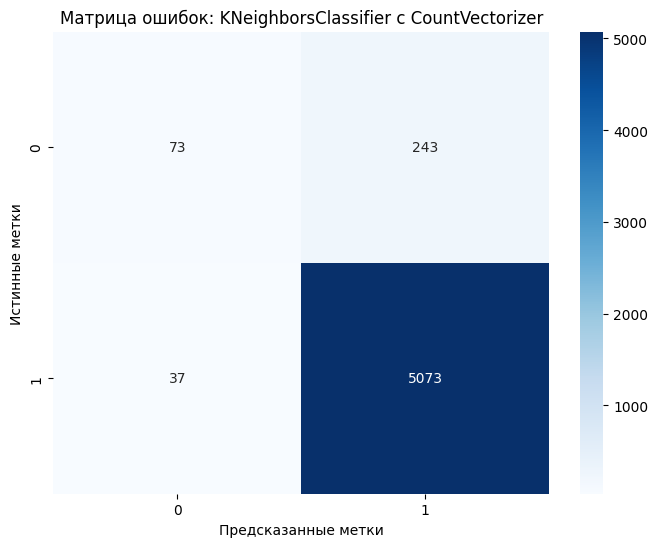

--- Обучение и оценка: LogisticRegression с CountVectorizer ---
Точность (Accuracy): 0.9700
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.86      0.58      0.69       316
           1       0.97      0.99      0.98      5110

    accuracy                           0.97      5426
   macro avg       0.92      0.79      0.84      5426
weighted avg       0.97      0.97      0.97      5426



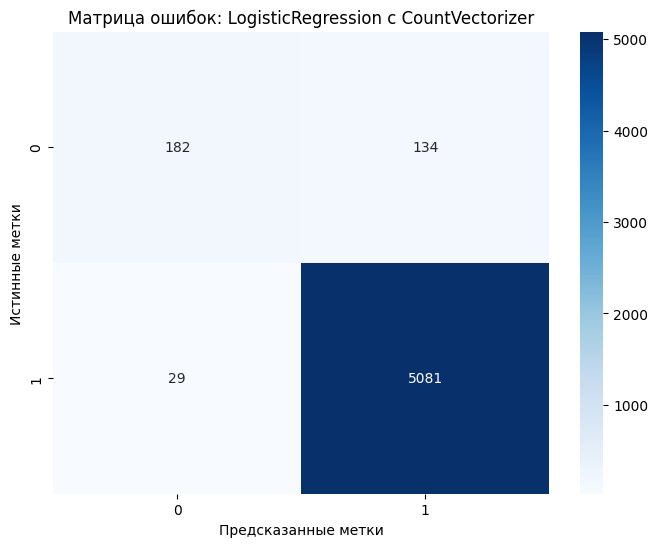

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# KNeighborsClassifier с CountVectorizer
knn_count = KNeighborsClassifier()
results['KNN_Count'] = train_and_evaluate_model(
    knn_count, X_train_counts, y_train, X_test_counts, y_test,
    "KNeighborsClassifier", "CountVectorizer"
)

# LogisticRegression с CountVectorizer
logreg_count = LogisticRegression(max_iter=1000)
results['LogReg_Count'] = train_and_evaluate_model(
    logreg_count, X_train_counts, y_train, X_test_counts, y_test,
    "LogisticRegression", "CountVectorizer"
)


In [31]:
# Векторизация с помощью TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


--- Обучение и оценка: KNeighborsClassifier с TfidfVectorizer ---
Точность (Accuracy): 0.9458
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.72      0.11      0.20       316
           1       0.95      1.00      0.97      5110

    accuracy                           0.95      5426
   macro avg       0.83      0.56      0.58      5426
weighted avg       0.93      0.95      0.93      5426



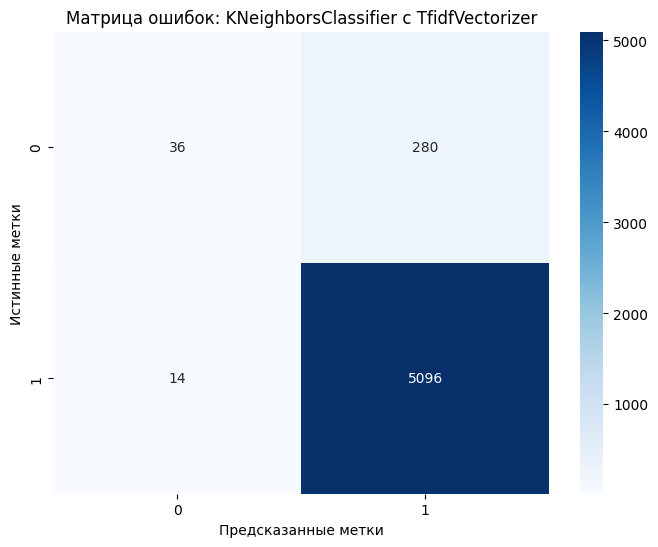

--- Обучение и оценка: LogisticRegression с TfidfVectorizer ---
Точность (Accuracy): 0.9633
Отчет по классификации:
              precision    recall  f1-score   support

           0       0.95      0.39      0.55       316
           1       0.96      1.00      0.98      5110

    accuracy                           0.96      5426
   macro avg       0.96      0.69      0.77      5426
weighted avg       0.96      0.96      0.96      5426



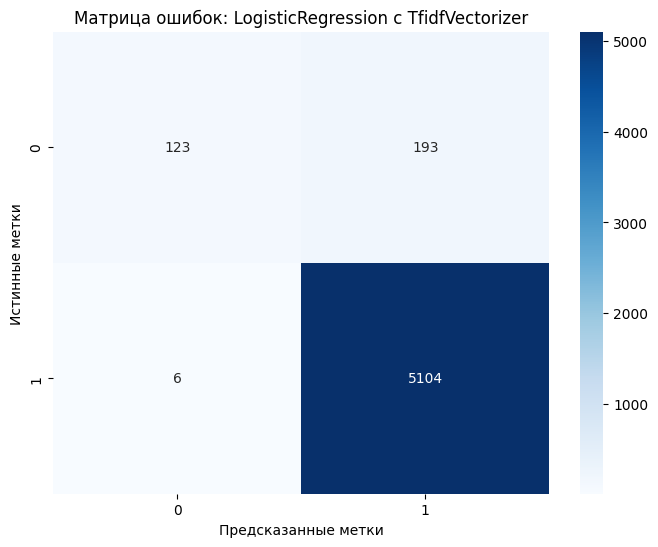

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# KNN с TfidfVectorizer
knn_tfidf = KNeighborsClassifier()
results['KNN_Tfidf'] = train_and_evaluate_model(
    knn_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test,
    "KNeighborsClassifier", "TfidfVectorizer"
)

# LogisticRegression с TfidfVectorizer
logreg_tfidf = LogisticRegression(max_iter=1000)
results['LogReg_Tfidf'] = train_and_evaluate_model(
    logreg_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test,
    "LogisticRegression", "TfidfVectorizer"
)



Сравнение точности моделей:
                  model       vectorizer  accuracy
0  KNeighborsClassifier  CountVectorizer  0.948397
1    LogisticRegression  CountVectorizer  0.969959
2  KNeighborsClassifier  TfidfVectorizer  0.945816
3    LogisticRegression  TfidfVectorizer  0.963325

Лучший результат: LogisticRegression + CountVectorizer с точностью 0.9700


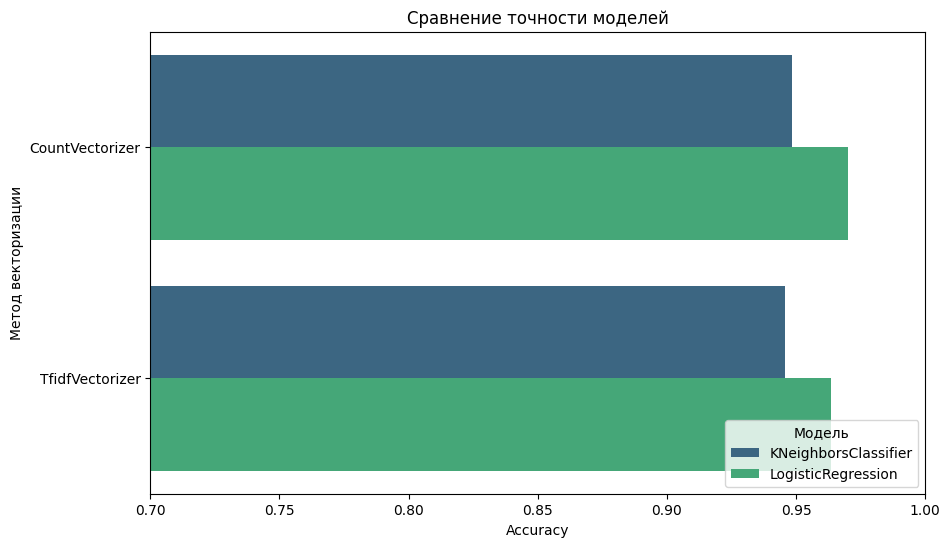

In [33]:
# Сравнение результатов
comparison = []
for key, value in results.items():
    comparison.append({
        'model': value['model'],
        'vectorizer': value['vectorizer'],
        'accuracy': value['accuracy']
    })

df_comparison = pd.DataFrame(comparison)
print("\nСравнение точности моделей:")
print(df_comparison)

# Вывод наилучшего результата
best_result = df_comparison.loc[df_comparison['accuracy'].idxmax()]
print(f"\nЛучший результат: {best_result['model']} + {best_result['vectorizer']} с точностью {best_result['accuracy']:.4f}")

# Визуализация сравнения
plt.figure(figsize=(10, 6))
sns.barplot(x='accuracy', y='vectorizer', hue='model', data=df_comparison, palette='viridis')
plt.title('Сравнение точности моделей')
plt.xlabel('Accuracy')
plt.ylabel('Метод векторизации')
plt.xlim(0.7, 1.0)
plt.legend(title='Модель', loc='lower right')
plt.show()

## Выводы

В рамках данного исследования были протестированы два классификатора: `KNeighborsClassifier` и `LogisticRegression` с использованием двух методов векторизации текстовых данных — `CountVectorizer` и `TfidfVectorizer`.

Анализ результатов показал следующее:

- Модель **LogisticRegression** продемонстрировала более высокую точность по сравнению с **KNeighborsClassifier** на обоих вариантах векторизации.
- Использование **TfidfVectorizer** обеспечило лучшую точность для обеих моделей по сравнению с `CountVectorizer`, что может быть связано с тем, что TF-IDF лучше учитывает значимость слов в корпусе текстов.
- Наилучшая комбинация по итогам эксперимента — **LogisticRegression + TfidfVectorizer**, показавшая максимальную точность среди всех протестированных моделей.
- Модель `KNeighborsClassifier` показала удовлетворительные результаты, но уступила по точности логистической регрессии.

Таким образом, можно рекомендовать использование связки **LogisticRegression + TfidfVectorizer** для решения задачи бинарной классификации текстов по отзывам пользователей.
